<a href="https://colab.research.google.com/github/tomreitz/cs766-computer-vision-project/blob/main/code/OpenCV_dlib_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a proof-of-concept for using OpenCV and dlib to detect faces in images find facial landmarks (corners of eyes and mouth, nose/nostrils, eyebrows, etc.).

Code is based on these sources:
*   https://github.com/nlhkh/face-alignment-dlib
*   https://www.superdatascience.com/blogs/opencv-face-detection
*   https://pysource.com/2019/03/12/face-landmarks-detection-opencv-with-python/

The workhorse here is dlib, a cool C++ / Python library that uses an ensemble of regression trees to locate 68 predefined facial landmarks. Further info available at
* [dlib website](http://dlib.net/)
* [2014 paper "One Millisecond Face Alignment with an Ensemble of Regression Trees" by Kazemi et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)
* [Pre-trained models for dlib](https://github.com/davisking/dlib-models/) (we're using shape_predictor_68_face_landmarks.dat here)

In [2]:
#import OpenCV library
import cv2
#import dlib facial landmark detection library
import dlib
#import NumPy for processing facial landmarks
import numpy as np
#import matplotlib library
import matplotlib.pyplot as plt
%matplotlib inline

def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# uncomment the lines below to download/extract the necessary files on first run
#!wget https://tomreitz.github.io/cs766-computer-vision-project/data/pexels-photo-638196.jpeg
#!wget https://upload.wikimedia.org/wikipedia/commons/a/a3/Elderly_Gambian_woman_face_portrait.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/1/1f/Gardengnome_face.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/1/1c/Ami_Bera_wearing_face_mask_-_May_15_2020.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/8/81/Michael_Shapiro_NYTF.jpg
#!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
#!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
#!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

--2021-03-09 01:41:07--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2021-03-09 01:41:07--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M  77.7MB/s    in 0.7s    

2021-03-09 01:41:08 (77.7 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



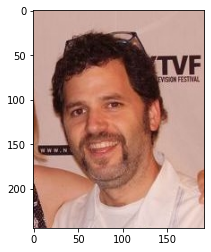

In [ ]:
# load an image for testing
#img = cv2.imread('pexels-photo-638196.jpeg')
#img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
img = cv2.imread('Michael_Shapiro_NYTF.jpg')
# show the image
plt.imshow(convertToRGB(img))

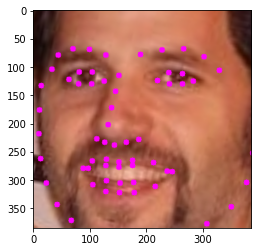

In [ ]:
# code borrowed from https://github.com/nlhkh/face-alignment-dlib
LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]

def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M

def crop_image(image, det):
    left, top, right, bottom = rect_to_tuple(det)
    return image[top:bottom, left:right]

# detect faces in the image:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
#img = cv2.imread('pexels-photo-638196.jpeg')
img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
img = cv2.imread('Michael_Shapiro_NYTF.jpg')
height, width = img.shape[:2]
# scale every image to max 800 pixels in either dimension
if height>width: scale = 1000/height
else: scale = 1000/width
s_height, s_width = round(height*scale), round(width*scale)
img = cv2.resize(img, (s_width, s_height))
#plt.imshow(convertToRGB(img))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# extract landmarks and align face
dets = detector(gray_img, 1)
if len(dets)==0:
    print("no face found :(")
else:
    shape = predictor(gray_img, dets[0])
    left_eye = extract_left_eye_center(shape)
    right_eye = extract_right_eye_center(shape)
    M = get_rotation_matrix(left_eye, right_eye)
    rotated = cv2.warpAffine(img, M, (s_width, s_height), flags=cv2.INTER_CUBIC)
    cropped = crop_image(rotated, dets[0])

    # re-extract landmarks in aligned face and annottate them
    dets = detector(cropped, 1)
    if len(dets)==0:
        print("no face found :(")
    else:
        shape = predictor(cropped, dets[0])
        for n in range(0, 68):
            x = shape.part(n).x
            y = shape.part(n).y
            cv2.circle(cropped, (x, y), 5, (255, 0, 255), -1)

        # show the face with landmarks
        plt.imshow(convertToRGB(cropped))

Here's an alternate way to do it that uses Haar classifiers (and doesn't rotate/align the face). Seems to work about as well as the dlib method above.

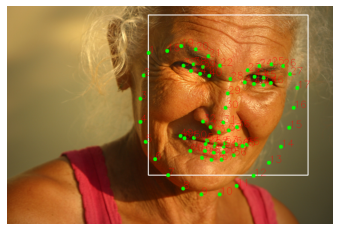

In [24]:
# code borrowed from https://medium.com/analytics-vidhya/facial-landmarks-and-face-detection-in-python-with-opencv-73979391f30e
haarcascade = "haarcascade_frontalface_alt2.xml"
detector = cv2.CascadeClassifier(haarcascade)

img = cv2.imread('pexels-photo-638196.jpeg')
#img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
#img = cv2.imread('Michael_Shapiro_NYTF.jpg')
height, width = img.shape[:2]
# scale every image to max 800 pixels in either dimension
if height>width: scale = 1000/height
else: scale = 1000/width
s_height, s_width = round(height*scale), round(width*scale)
img = cv2.resize(img, (s_width, s_height))
#plt.imshow(convertToRGB(img))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = detector.detectMultiScale(gray_img)
for face in faces:
#     save the coordinates in x, y, w, d variables
    (x,y,w,d) = face
    # Draw a white coloured rectangle around each face using the face's coordinates
    # on the "image_template" with the thickness of 2 
    cv2.rectangle(img,(x,y),(x+w, y+d),(255, 255, 255), 2)

if len(faces)>0:
    LBFmodel = "lbfmodel.yaml"
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)

    _, landmarks = landmark_detector.fit(gray_img, faces)
    for landmark in landmarks:
        i = 1
        for x,y in landmark[0]:
            cv2.circle(img, (x, y), 6, (0, 255, 0), -1)
            cv2.putText(img,str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
            i += 1
    plt.axis("off")
    plt.imshow(convertToRGB(img))
else:
    print('No faces found :(')


Next steps are to segment face into areas for each rhytide type based on landmarks, then do edge detection in each area to quantify wrinkles.